In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/feature domain/Beta_frequency.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

In [7]:
# %%capture
# !pip install wandb

In [8]:
# import wandb
# !wandb login

# CNN-LSTM

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_callback = ModelCheckpoint(
                f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta/best_model_{run_name}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Evaluate client model
            y_pred = (client_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [10]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Train shape: (4640, 19, 29), Test shape: (1194, 19, 29)
Train shape: (4418, 19, 29), Test shape: (1416, 19, 29)
Train shape: (4838, 19, 29), Test shape: (996, 19, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 19, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 19s 268ms/step - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6931 - val_accuracy: 0.4957
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.6930 - accuracy: 0.5784 - val_loss: 0.6932 - val_accuracy: 0.4838
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5835 - val_loss: 0.6932 - val_accuracy: 0.4871
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5881 - val_loss: 0.6932 - val_accuracy: 0.4914
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.6921 - accuracy: 0.5854 - val_loss: 0.6931 - val_accuracy: 0.4946
Epoch 6/100
29/29 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.5892 - val_loss: 0.6931 - val_accuracy: 0.4957
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 0.6909 - accuracy: 0.5876 - val_loss: 0.6930 - val_accuracy: 0.5022
Epoch 8/100
29/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 11s 107ms/step - loss: 0.6931 - accuracy: 0.5156 - val_loss: 0.6931 - val_accuracy: 0.4977
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.5424 - val_loss: 0.6931 - val_accuracy: 0.4932
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5608 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5557 - val_loss: 0.6932 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.6926 - accuracy: 0.5702 - val_loss: 0.6931 - val_accuracy: 0.4966
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.6924 - accuracy: 0.5659 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 7/100
28/28 [==============================] - 1s 24ms/step - loss: 0.6920 - accuracy: 0.5685 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 8/100
28/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 65ms/step - loss: 0.6931 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5145
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6931 - accuracy: 0.5527 - val_loss: 0.6932 - val_accuracy: 0.4804
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.5579 - val_loss: 0.6932 - val_accuracy: 0.4773
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6929 - accuracy: 0.5625 - val_loss: 0.6932 - val_accuracy: 0.4773
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5527 - val_loss: 0.6932 - val_accuracy: 0.4793
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6927 - accuracy: 0.5625 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6925 - accuracy: 0.5610 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 98ms/step - loss: 0.5937 - accuracy: 0.6953 - val_loss: 0.6937 - val_accuracy: 0.4871
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5853 - accuracy: 0.7042 - val_loss: 0.6935 - val_accuracy: 0.4903
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5820 - accuracy: 0.7007 - val_loss: 0.6919 - val_accuracy: 0.4903
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.5799 - accuracy: 0.6988 - val_loss: 0.6923 - val_accuracy: 0.4925
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.5763 - accuracy: 0.7053 - val_loss: 0.6948 - val_accuracy: 0.4881
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.5704 - accuracy: 0.7069 - val_loss: 0.6881 - val_accuracy: 0.5065
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.5671 - accuracy: 0.7139 - val_loss: 0.6871 - val_accuracy: 0.5140
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 59ms/step - loss: 0.6027 - accuracy: 0.6862 - val_loss: 0.6930 - val_accuracy: 0.4989
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5958 - accuracy: 0.6921 - val_loss: 0.6926 - val_accuracy: 0.5011
Epoch 3/100
28/28 [==============================] - 1s 24ms/step - loss: 0.5950 - accuracy: 0.6907 - val_loss: 0.6920 - val_accuracy: 0.5023
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.5907 - accuracy: 0.6944 - val_loss: 0.6925 - val_accuracy: 0.5045
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5911 - accuracy: 0.6882 - val_loss: 0.6887 - val_accuracy: 0.5192
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.5870 - accuracy: 0.6944 - val_loss: 0.6889 - val_accuracy: 0.5158
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.5824 - accuracy: 0.7049 - val_loss: 0.6880 - val_accuracy: 0.5192
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 62ms/step - loss: 0.6098 - accuracy: 0.6778 - val_loss: 0.6942 - val_accuracy: 0.4917
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 0.5984 - accuracy: 0.6879 - val_loss: 0.6935 - val_accuracy: 0.4938
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 0.5920 - accuracy: 0.6902 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 4/100
31/31 [==============================] - 1s 31ms/step - loss: 0.5906 - accuracy: 0.6928 - val_loss: 0.6902 - val_accuracy: 0.5052
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 0.5898 - accuracy: 0.6928 - val_loss: 0.6864 - val_accuracy: 0.5124
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.5843 - accuracy: 0.7008 - val_loss: 0.6888 - val_accuracy: 0.5083
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5821 - accuracy: 0.6997 - val_loss: 0.6831 - val_accuracy: 0.5227
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 59ms/step - loss: 0.4231 - accuracy: 0.8066 - val_loss: 0.8347 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 16ms/step - loss: 0.4130 - accuracy: 0.8087 - val_loss: 0.8423 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.4119 - accuracy: 0.8103 - val_loss: 0.8430 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 22ms/step - loss: 0.4065 - accuracy: 0.8077 - val_loss: 0.8442 - val_accuracy: 0.4860
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.4067 - accuracy: 0.8128 - val_loss: 0.8482 - val_accuracy: 0.4860
Epoch 6/100
29/29 [==============================] - 1s 22ms/step - loss: 0.4009 - accuracy: 0.8238 - val_loss: 0.8471 - val_accuracy: 0.4871
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3935 - accuracy: 0.8249 - val_loss: 0.8404 - val_accuracy: 0.4860
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 58ms/step - loss: 0.4514 - accuracy: 0.7932 - val_loss: 0.8169 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 17ms/step - loss: 0.4310 - accuracy: 0.7954 - val_loss: 0.8189 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 0.4255 - accuracy: 0.8014 - val_loss: 0.8215 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.4154 - accuracy: 0.8070 - val_loss: 0.8199 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 0.4267 - accuracy: 0.8011 - val_loss: 0.8202 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 31ms/step - loss: 0.4202 - accuracy: 0.8053 - val_loss: 0.8239 - val_accuracy: 0.4966
Epoch 7/100
28/28 [==============================] - 1s 36ms/step - loss: 0.4157 - accuracy: 0.8014 - val_loss: 0.8222 - val_accuracy: 0.4989
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 75ms/step - loss: 0.4633 - accuracy: 0.7791 - val_loss: 0.8274 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 0.4406 - accuracy: 0.7902 - val_loss: 0.8202 - val_accuracy: 0.4876
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.4270 - accuracy: 0.7992 - val_loss: 0.8210 - val_accuracy: 0.4876
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.4257 - accuracy: 0.8000 - val_loss: 0.8260 - val_accuracy: 0.4876
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.4225 - accuracy: 0.7977 - val_loss: 0.8236 - val_accuracy: 0.4886
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.4184 - accuracy: 0.8021 - val_loss: 0.8262 - val_accuracy: 0.4907
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 0.4072 - accuracy: 0.8096 - val_loss: 0.8289 - val_accuracy: 0.4928
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 72ms/step - loss: 0.2883 - accuracy: 0.8834 - val_loss: 1.1688 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 19ms/step - loss: 0.2978 - accuracy: 0.8745 - val_loss: 1.1550 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.2760 - accuracy: 0.8882 - val_loss: 1.1511 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 30ms/step - loss: 0.2604 - accuracy: 0.8874 - val_loss: 1.1489 - val_accuracy: 0.4860
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.2523 - accuracy: 0.8955 - val_loss: 1.1656 - val_accuracy: 0.4860
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.2534 - accuracy: 0.8982 - val_loss: 1.1558 - val_accuracy: 0.4860
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.2520 - accuracy: 0.8971 - val_loss: 1.1546 - val_accuracy: 0.4860
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 60ms/step - loss: 0.3061 - accuracy: 0.8696 - val_loss: 1.1221 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.2767 - accuracy: 0.8806 - val_loss: 1.1222 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.2729 - accuracy: 0.8806 - val_loss: 1.1171 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 0s 15ms/step - loss: 0.2644 - accuracy: 0.8834 - val_loss: 1.1202 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 0.2652 - accuracy: 0.8817 - val_loss: 1.1166 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.2599 - accuracy: 0.8882 - val_loss: 1.1246 - val_accuracy: 0.4966
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 0.2567 - accuracy: 0.8928 - val_loss: 1.1276 - val_accuracy: 0.4977
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 55ms/step - loss: 0.3190 - accuracy: 0.8618 - val_loss: 1.1439 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.2994 - accuracy: 0.8690 - val_loss: 1.1229 - val_accuracy: 0.4866
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.2965 - accuracy: 0.8718 - val_loss: 1.1256 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.2794 - accuracy: 0.8811 - val_loss: 1.1145 - val_accuracy: 0.4876
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2745 - accuracy: 0.8809 - val_loss: 1.1189 - val_accuracy: 0.4876
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 0.2712 - accuracy: 0.8845 - val_loss: 1.1340 - val_accuracy: 0.4876
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2959 - accuracy: 0.8747 - val_loss: 1.1195 - val_accuracy: 0.4917
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 76ms/step - loss: 0.2242 - accuracy: 0.9189 - val_loss: 1.4595 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.1921 - accuracy: 0.9211 - val_loss: 1.4580 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 31ms/step - loss: 0.1772 - accuracy: 0.9329 - val_loss: 1.4421 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 1s 17ms/step - loss: 0.1889 - accuracy: 0.9297 - val_loss: 1.4357 - val_accuracy: 0.4860
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.1730 - accuracy: 0.9337 - val_loss: 1.4566 - val_accuracy: 0.4860
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.1627 - accuracy: 0.9348 - val_loss: 1.4663 - val_accuracy: 0.4860
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.1613 - accuracy: 0.9386 - val_loss: 1.4566 - val_accuracy: 0.4860
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 62ms/step - loss: 0.2132 - accuracy: 0.9143 - val_loss: 1.4340 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 17ms/step - loss: 0.1816 - accuracy: 0.9295 - val_loss: 1.4094 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.1672 - accuracy: 0.9315 - val_loss: 1.4175 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.9338 - val_loss: 1.4050 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 0.1690 - accuracy: 0.9273 - val_loss: 1.4298 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 24ms/step - loss: 0.1657 - accuracy: 0.9358 - val_loss: 1.4249 - val_accuracy: 0.4966
Epoch 7/100
28/28 [==============================] - 1s 26ms/step - loss: 0.1740 - accuracy: 0.9290 - val_loss: 1.4328 - val_accuracy: 0.4977
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 61ms/step - loss: 0.2266 - accuracy: 0.9106 - val_loss: 1.4143 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.2118 - accuracy: 0.9106 - val_loss: 1.4227 - val_accuracy: 0.4866
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 0.1914 - accuracy: 0.9243 - val_loss: 1.4025 - val_accuracy: 0.4876
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 0.1911 - accuracy: 0.9199 - val_loss: 1.4304 - val_accuracy: 0.4876
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 0.2035 - accuracy: 0.9186 - val_loss: 1.4578 - val_accuracy: 0.4876
Epoch 6/100
31/31 [==============================] - 1s 32ms/step - loss: 0.1888 - accuracy: 0.9243 - val_loss: 1.4453 - val_accuracy: 0.4886
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 0.1720 - accuracy: 0.9331 - val_loss: 1.4181 - val_accuracy: 0.4917
Epoch 8/100
31/31 

In [11]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.551,0.551,0.551,0.551,0.551,0.551,0.102
1,1,0.603,0.591,0.671,0.628,0.671,0.535,0.206
2,2,0.592,0.577,0.693,0.630,0.693,0.492,0.185
3,0,0.598,0.580,0.714,0.640,0.714,0.482,0.196
4,1,0.648,0.652,0.633,0.642,0.633,0.662,0.295
5,2,0.636,0.614,0.729,0.667,0.729,0.542,0.271
6,0,0.659,0.659,0.660,0.659,0.660,0.658,0.318
7,1,0.698,0.685,0.732,0.708,0.732,0.664,0.395
8,2,0.708,0.696,0.739,0.717,0.739,0.677,0.416
9,0,0.700,0.667,0.799,0.727,0.799,0.601,0.400


In [12]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Frequency Domain/Beta_CNN_LSTM.csv', index = False)

#Draw CNN_LSTM

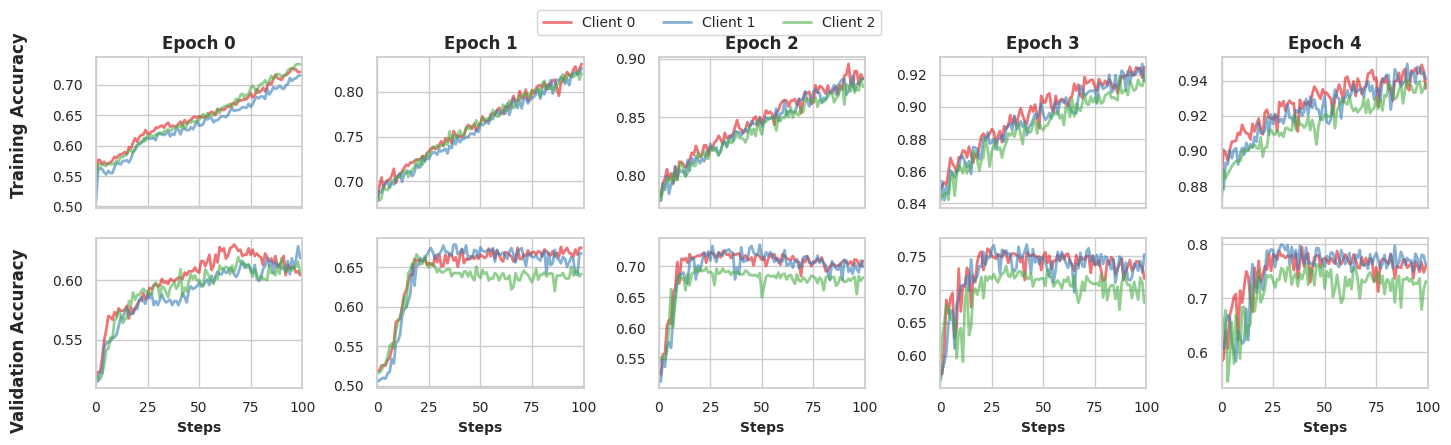

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy
def plot_accuracy(all_metrics_df, unique_epochs, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create subplots for each epoch
    fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Iterate through each epoch and plot the training and validation accuracy
    for i, epoch in enumerate(unique_epochs):
        epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
        for j, client in enumerate(epoch_df['client_number'].unique()):
            client_df = epoch_df[epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
            if not client_df.empty:
                line, = axes[0, i].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
                axes[1, i].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

                if i == 0:
                    lines.append(line)
                    labels.append(f'Client {client}')

        axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
        axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
        axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
        axes[0, i].grid(True)
        axes[1, i].grid(True)
        axes[0, i].tick_params(axis='both', which='major', labelsize=10)
        axes[1, i].tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

    # Add row labels
    fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Get unique epochs from the dataframe
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Plot the accuracy
plot_accuracy(all_metrics_df, unique_epochs, output_dir)


Final Epoch: 4
Average Training Accuracy: 0.9229
Average Validation Accuracy: 0.7394


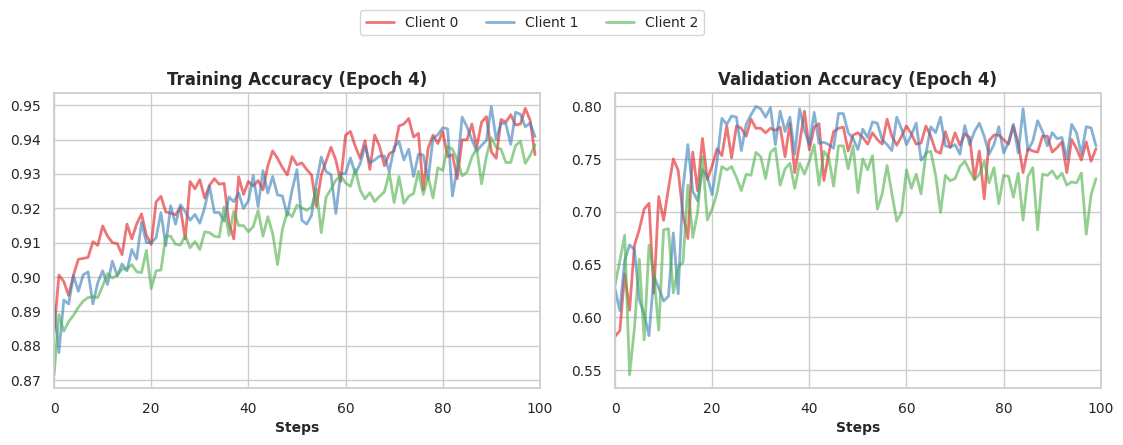

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Function to read CSV logs and extract accuracy and validation accuracy
def read_logs(log_dir, num_clients, local_epochs):
    dataframes = []
    for epoch in range(local_epochs):
        for client in range(num_clients):
            log_file = os.path.join(log_dir, f'training_log_epoch_{epoch}_client_{client}.csv')
            if os.path.exists(log_file):
                df = pd.read_csv(log_file, sep=';')
                df['epoch_number'] = epoch
                df['client_number'] = client
                dataframes.append(df)
            else:
                print(f"Log file not found: {log_file}")

    return pd.concat(dataframes) if dataframes else pd.DataFrame()

# Function to plot the training and validation accuracy for the final epoch
def plot_final_epoch_accuracy(all_metrics_df, output_dir):
    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Get the final epoch number
    final_epoch = all_metrics_df['epoch_number'].max()

    # Filter the data for the final epoch
    final_epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == final_epoch]

    # Calculate the average training and validation accuracy for the final epoch
    avg_train_accuracy = final_epoch_df['accuracy'].mean()
    avg_val_accuracy = final_epoch_df['val_accuracy'].mean()

    print(f"Final Epoch: {final_epoch}")
    print(f"Average Training Accuracy: {avg_train_accuracy:.4f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

    # Create subplots for the final epoch
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

    # Set the color palette
    palette = sns.color_palette("Set1", n_colors=final_epoch_df['client_number'].nunique())

    # Store the lines and labels for the legend
    lines = []
    labels = []

    # Plot the training and validation accuracy for the final epoch
    for client in final_epoch_df['client_number'].unique():
        client_df = final_epoch_df[final_epoch_df['client_number'] == client].dropna(subset=['accuracy', 'val_accuracy'])
        if not client_df.empty:
            line, = axes[0].plot(client_df.index, client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)
            axes[1].plot(client_df.index, client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[client], linewidth=2.0)

            if len(lines) < final_epoch_df['client_number'].nunique():
                lines.append(line)
                labels.append(f'Client {client}')

    axes[0].set_title(f'Training Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps

    axes[1].set_title(f'Validation Accuracy (Epoch {final_epoch})', fontsize=12, fontweight='bold')


    for ax in axes:
        ax.set_xlabel('Steps', fontsize=10, fontweight='bold')
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a single legend for the entire figure
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=10, frameon=True)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.2, top=0.85)  # Add some space between the rows and reduce space between the legend and plot

    # Save the figure in high DPI PNG and PDF
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.png'), dpi=300, format='png')
    fig.savefig(os.path.join(output_dir, 'final_epoch_accuracy_plot.pdf'), dpi=300, format='pdf')

    plt.show()

# Directory where CSV logs are saved
log_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta'

# Output directory for saving plots
output_dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Frequency_domain/Beta/plots'

# Number of clients and local epochs
num_clients = 3
local_epochs = 5

# Read logs and generate the dataframe
all_metrics_df = read_logs(log_dir, num_clients, local_epochs)

# Plot the accuracy for the final epoch
plot_final_epoch_accuracy(all_metrics_df, output_dir)


# CNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM,Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from keras.optimizers import RMSprop, Adam
from wandb.keras import WandbCallback

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', k_folds=5, stratified=False):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.k_folds = k_folds
        self.stratified = stratified
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle= True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        X = scaled_data_reshaped.reshape(self.X.shape)
        np.moveaxis(X, 1, 2)
        self.X = X

    def create_partitions(self):
        if self.stratified:
            kf = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        else:
            kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        for train_index, test_index in kf.split(self.X, self.Y):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
        # GRU layers
    # model.add(GRU(256, return_sequences=True))
    # model.add(GRU(128, return_sequences=False))

    model.add(Flatten())
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            run_name = f"epoch_{epoch}_client_{client}"
            wandb.init(project="Beta_time_domain_CNN", entity="RaihanRabby",
                       dir = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/wandb',
                       name=run_name
                       )
            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[WandbCallback()])
            client_models.append(client_model)

            print(history.history)

            # Evaluate client model
            y_pred = (client_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df
# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4668, 18, 29), Test shape: (1166, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4667, 18, 29), Test shape: (1167, 18, 29)
Train shape: (4668, 18, 29), Test shape: (1166, 18, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 18, 256)           1024      
 Normalization)                                                  
                        

accuracy,▁▃▃▄▄▃▄▃▄▅▄▅▅▆▆▆▇▄▆▆▆▆▆▇▆▆▇▇▆▆▇▇█▆█▇▅███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▆▅▅▅▆▅▄▅▄▄▄▃▄▃▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▁▃▁▂▄▁▁▁
val_accuracy,▁▁▁▁▂▄▅▅▆▇▇▇█▇█▇█████████▇▇█▇██████▇███▇
val_loss,█▇▆▆▆▄▃▄▄▂▁▂▁▃▁▃▂▁▂▃▃▂▃▂▃▆▄▃▇▃▄▃▄▄▄▄▃▄▅▆
accuracy,0.96384
best_epoch,32
best_val_loss,0.52096
epoch,99
loss,0.08816
val_accuracy,0.77516


Epoch 1/100
30/30 [==============================] - 6s 29ms/step - loss: 0.6830 - accuracy: 0.6014 - val_loss: 0.6929 - val_accuracy: 0.4989
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 0.6654 - accuracy: 0.6432 - val_loss: 0.6929 - val_accuracy: 0.4989
Epoch 3/100
30/30 [==============================] - 0s 13ms/step - loss: 0.6545 - accuracy: 0.6408 - val_loss: 0.6923 - val_accuracy: 0.4989
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.6440 - accuracy: 0.6456 - val_loss: 0.6920 - val_accuracy: 0.4989
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 0.6292 - accuracy: 0.6729 - val_loss: 0.6906 - val_accuracy: 0.4989
Epoch 6/100
30/30 [==============================] - 0s 14ms/step - loss: 0.6187 - accuracy: 0.6772 - val_loss: 0.6889 - val_accuracy: 0.4989
Epoch 7/100
30/30 [==============================] - 0s 14ms/step - loss: 0.6064 - accuracy: 0.6911 - val_loss: 0.6864 - val_accuracy: 0.4989
Epoch 

Epoch 1/100
30/30 [==============================] - 4s 22ms/step - loss: 0.6842 - accuracy: 0.5851 - val_loss: 0.6931 - val_accuracy: 0.4861
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6652 - accuracy: 0.6686 - val_loss: 0.6934 - val_accuracy: 0.4861
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6534 - accuracy: 0.6381 - val_loss: 0.6925 - val_accuracy: 0.4861
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6371 - accuracy: 0.6708 - val_loss: 0.6921 - val_accuracy: 0.4861
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6250 - accuracy: 0.6834 - val_loss: 0.6931 - val_accuracy: 0.4861
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6111 - accuracy: 0.6954 - val_loss: 0.6915 - val_accuracy: 0.4861
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6001 - accuracy: 0.7010 - val_loss: 0.6892 - val_accuracy: 0.4861
Epoch 

Epoch 1/100
30/30 [==============================] - 4s 23ms/step - loss: 0.6849 - accuracy: 0.5591 - val_loss: 0.6926 - val_accuracy: 0.5043
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.6704 - accuracy: 0.6065 - val_loss: 0.6918 - val_accuracy: 0.5043
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6602 - accuracy: 0.6284 - val_loss: 0.6914 - val_accuracy: 0.5043
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6446 - accuracy: 0.6585 - val_loss: 0.6898 - val_accuracy: 0.5043
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6317 - accuracy: 0.6879 - val_loss: 0.6897 - val_accuracy: 0.5043
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6191 - accuracy: 0.6879 - val_loss: 0.6843 - val_accuracy: 0.5043
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.6098 - accuracy: 0.6882 - val_loss: 0.6854 - val_accuracy: 0.5043
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 22ms/step - loss: 0.4768 - accuracy: 0.7680 - val_loss: 0.7410 - val_accuracy: 0.4989
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.4634 - accuracy: 0.7744 - val_loss: 0.7436 - val_accuracy: 0.4989
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.4610 - accuracy: 0.7811 - val_loss: 0.7506 - val_accuracy: 0.4989
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.4606 - accuracy: 0.7790 - val_loss: 0.7522 - val_accuracy: 0.4989
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.4510 - accuracy: 0.7862 - val_loss: 0.7559 - val_accuracy: 0.4989
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 0.4483 - accuracy: 0.7838 - val_loss: 0.7516 - val_accuracy: 0.4989
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.4461 - accuracy: 0.7894 - val_loss: 0.7735 - val_accuracy: 0.4989
Epoch 

Epoch 1/100
30/30 [==============================] - 4s 31ms/step - loss: 0.4762 - accuracy: 0.7664 - val_loss: 0.7451 - val_accuracy: 0.4861
Epoch 2/100
30/30 [==============================] - 0s 16ms/step - loss: 0.4657 - accuracy: 0.7779 - val_loss: 0.7526 - val_accuracy: 0.4861
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4571 - accuracy: 0.7811 - val_loss: 0.7524 - val_accuracy: 0.4861
Epoch 4/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4644 - accuracy: 0.7817 - val_loss: 0.7593 - val_accuracy: 0.4861
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4503 - accuracy: 0.7881 - val_loss: 0.7665 - val_accuracy: 0.4861
Epoch 6/100
30/30 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.7921 - val_loss: 0.7660 - val_accuracy: 0.4861
Epoch 7/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4474 - accuracy: 0.7929 - val_loss: 0.7608 - val_accuracy: 0.4861
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 26ms/step - loss: 0.4792 - accuracy: 0.7656 - val_loss: 0.7390 - val_accuracy: 0.5043
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 0.4635 - accuracy: 0.7779 - val_loss: 0.7437 - val_accuracy: 0.5043
Epoch 3/100
30/30 [==============================] - 0s 13ms/step - loss: 0.4571 - accuracy: 0.7833 - val_loss: 0.7429 - val_accuracy: 0.5043
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4529 - accuracy: 0.7836 - val_loss: 0.7474 - val_accuracy: 0.5043
Epoch 5/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4507 - accuracy: 0.7827 - val_loss: 0.7508 - val_accuracy: 0.5043
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.4540 - accuracy: 0.7750 - val_loss: 0.7321 - val_accuracy: 0.5043
Epoch 7/100
30/30 [==============================] - 0s 12ms/step - loss: 0.4668 - accuracy: 0.7747 - val_loss: 0.7709 - val_accuracy: 0.5043
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 23ms/step - loss: 0.3613 - accuracy: 0.8302 - val_loss: 0.8903 - val_accuracy: 0.4989
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 0.3349 - accuracy: 0.8527 - val_loss: 0.9067 - val_accuracy: 0.4989
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.3221 - accuracy: 0.8553 - val_loss: 0.9287 - val_accuracy: 0.4989
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 0.3222 - accuracy: 0.8548 - val_loss: 0.9752 - val_accuracy: 0.4989
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.3175 - accuracy: 0.8599 - val_loss: 0.9984 - val_accuracy: 0.4989
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.3193 - accuracy: 0.8626 - val_loss: 1.0807 - val_accuracy: 0.4989
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.3098 - accuracy: 0.8711 - val_loss: 1.1320 - val_accuracy: 0.4989
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 22ms/step - loss: 0.3755 - accuracy: 0.8280 - val_loss: 0.8959 - val_accuracy: 0.4861
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3336 - accuracy: 0.8537 - val_loss: 0.9212 - val_accuracy: 0.4861
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 0.3319 - accuracy: 0.8612 - val_loss: 0.9443 - val_accuracy: 0.4861
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 0.3265 - accuracy: 0.8602 - val_loss: 0.9752 - val_accuracy: 0.4861
Epoch 5/100
30/30 [==============================] - 0s 12ms/step - loss: 0.3283 - accuracy: 0.8618 - val_loss: 1.0179 - val_accuracy: 0.4861
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.3151 - accuracy: 0.8685 - val_loss: 1.0862 - val_accuracy: 0.4861
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.3356 - accuracy: 0.8519 - val_loss: 1.1241 - val_accuracy: 0.4861
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 29ms/step - loss: 0.3534 - accuracy: 0.8390 - val_loss: 0.8751 - val_accuracy: 0.5043
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.3288 - accuracy: 0.8503 - val_loss: 0.8900 - val_accuracy: 0.5043
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.3229 - accuracy: 0.8588 - val_loss: 0.9088 - val_accuracy: 0.5043
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3374 - accuracy: 0.8462 - val_loss: 0.9473 - val_accuracy: 0.5043
Epoch 5/100
30/30 [==============================] - 0s 14ms/step - loss: 0.3164 - accuracy: 0.8591 - val_loss: 0.9839 - val_accuracy: 0.5043
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.3143 - accuracy: 0.8615 - val_loss: 1.0339 - val_accuracy: 0.5043
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.3096 - accuracy: 0.8669 - val_loss: 1.0710 - val_accuracy: 0.5043
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 21ms/step - loss: 0.2895 - accuracy: 0.8685 - val_loss: 1.1828 - val_accuracy: 0.4989
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.2131 - accuracy: 0.9108 - val_loss: 1.1863 - val_accuracy: 0.4989
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 0.1998 - accuracy: 0.9207 - val_loss: 1.2415 - val_accuracy: 0.4989
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2056 - accuracy: 0.9194 - val_loss: 1.3350 - val_accuracy: 0.4989
Epoch 5/100
30/30 [==============================] - 0s 12ms/step - loss: 0.2193 - accuracy: 0.9076 - val_loss: 1.4153 - val_accuracy: 0.4989
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1859 - accuracy: 0.9349 - val_loss: 1.5213 - val_accuracy: 0.4989
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.2042 - accuracy: 0.9175 - val_loss: 1.5826 - val_accuracy: 0.4989
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 23ms/step - loss: 0.2559 - accuracy: 0.8891 - val_loss: 1.1917 - val_accuracy: 0.4861
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2181 - accuracy: 0.9100 - val_loss: 1.2191 - val_accuracy: 0.4861
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 0.2019 - accuracy: 0.9194 - val_loss: 1.2599 - val_accuracy: 0.4861
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2023 - accuracy: 0.9239 - val_loss: 1.3371 - val_accuracy: 0.4861
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1938 - accuracy: 0.9242 - val_loss: 1.4243 - val_accuracy: 0.4861
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1912 - accuracy: 0.9266 - val_loss: 1.5494 - val_accuracy: 0.4861
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1955 - accuracy: 0.9253 - val_loss: 1.6357 - val_accuracy: 0.4861
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 22ms/step - loss: 0.2726 - accuracy: 0.8811 - val_loss: 1.1417 - val_accuracy: 0.5043
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2075 - accuracy: 0.9212 - val_loss: 1.1791 - val_accuracy: 0.5043
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.2079 - accuracy: 0.9207 - val_loss: 1.2273 - val_accuracy: 0.5043
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1999 - accuracy: 0.9237 - val_loss: 1.2820 - val_accuracy: 0.5043
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 0.1953 - accuracy: 0.9285 - val_loss: 1.3967 - val_accuracy: 0.5043
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1941 - accuracy: 0.9255 - val_loss: 1.4772 - val_accuracy: 0.5043
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1877 - accuracy: 0.9287 - val_loss: 1.6255 - val_accuracy: 0.5043
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 22ms/step - loss: 0.2499 - accuracy: 0.8958 - val_loss: 1.5705 - val_accuracy: 0.4989
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.1215 - accuracy: 0.9585 - val_loss: 1.5907 - val_accuracy: 0.4989
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1107 - accuracy: 0.9657 - val_loss: 1.6720 - val_accuracy: 0.4989
Epoch 4/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1222 - accuracy: 0.9539 - val_loss: 1.7899 - val_accuracy: 0.4989
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1108 - accuracy: 0.9644 - val_loss: 1.8720 - val_accuracy: 0.4989
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1162 - accuracy: 0.9593 - val_loss: 2.0328 - val_accuracy: 0.4989
Epoch 7/100
30/30 [==============================] - 0s 12ms/step - loss: 0.1009 - accuracy: 0.9679 - val_loss: 2.2364 - val_accuracy: 0.4989
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 27ms/step - loss: 0.2108 - accuracy: 0.9095 - val_loss: 1.6029 - val_accuracy: 0.4861
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1371 - accuracy: 0.9429 - val_loss: 1.6264 - val_accuracy: 0.4861
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1160 - accuracy: 0.9620 - val_loss: 1.6980 - val_accuracy: 0.4861
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.1059 - accuracy: 0.9641 - val_loss: 1.8190 - val_accuracy: 0.4861
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 0.1071 - accuracy: 0.9662 - val_loss: 1.9802 - val_accuracy: 0.4861
Epoch 6/100
30/30 [==============================] - 0s 17ms/step - loss: 0.1467 - accuracy: 0.9421 - val_loss: 2.0086 - val_accuracy: 0.4861
Epoch 7/100
30/30 [==============================] - 0s 14ms/step - loss: 0.1055 - accuracy: 0.9668 - val_loss: 2.2516 - val_accuracy: 0.4861
Epoch 

Epoch 1/100
30/30 [==============================] - 3s 23ms/step - loss: 0.2732 - accuracy: 0.8896 - val_loss: 1.5271 - val_accuracy: 0.5043
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.1377 - accuracy: 0.9456 - val_loss: 1.5541 - val_accuracy: 0.5043
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1162 - accuracy: 0.9585 - val_loss: 1.6516 - val_accuracy: 0.5043
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1085 - accuracy: 0.9673 - val_loss: 1.7221 - val_accuracy: 0.5043
Epoch 5/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1132 - accuracy: 0.9590 - val_loss: 1.8986 - val_accuracy: 0.5043
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1113 - accuracy: 0.9638 - val_loss: 1.9998 - val_accuracy: 0.5043
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1059 - accuracy: 0.9662 - val_loss: 2.1659 - val_accuracy: 0.5043
Epoch 

In [ ]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.744,0.756,0.724,0.740,0.724,0.764,0.488
1,1,0.722,0.754,0.666,0.707,0.666,0.779,0.444
2,2,0.749,0.831,0.625,0.714,0.625,0.873,0.498
3,0,0.750,0.723,0.814,0.766,0.814,0.684,0.499
4,1,0.745,0.758,0.727,0.742,0.727,0.763,0.489
5,2,0.771,0.774,0.767,0.770,0.767,0.775,0.542
6,0,0.793,0.800,0.785,0.793,0.785,0.802,0.587
7,1,0.761,0.725,0.847,0.782,0.847,0.673,0.521
8,2,0.793,0.774,0.827,0.800,0.827,0.758,0.585
9,0,0.817,0.800,0.850,0.824,0.850,0.784,0.635


In [ ]:
metrics_df_CNN.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Time Domain/Beta_time_CNN.csv', index = False)